# Classification of quantum states with high dimensional entanglement 

This notebook for saving the transpiled circuits. These are saved as qasm strings in a dictionay.
The first section on creating circuits for the simulator before transpilation for real device was maintained.


## Circuits and computations
Version compatible with 1st and 2d pilot studies (not tested on 1st pilot study)

In [1]:
import numpy as np
import copy
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.tools.visualization import *
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import json
from scipy.signal import savgol_filter
import time
from qiskit.tools.monitor import job_monitor

In [2]:
from o_utils import ora # classifier utilities
from o_plot import opl # utilities for result plot
from c_utils import new_cut # circuit building utilities

In [3]:
def json_dic_loader(dic_name):
    f = open(data_directory+dic_name+'.json')
    return json.load(f)

In [4]:
###markdown for safety on demo
def json_dic_dumper(dic, dic_name):
    with open(data_directory+dic_name+'.json', 'w') as f:
        json.dump(dic,f)   

## Set up the simulator and layout for 5 qubits

In [5]:
simulator = Aer.get_backend('qasm_simulator')

In [6]:
#specify the layout of the devices
used_qubits = 5
qubit_list = [0,1,2,3,4]

In [7]:
#short_version = False
#program_name="QAD" # 1st pilot project GHZ Psi+ / W Phi+
program_name="AL2" # 2d pilot project W Psi+ / Wbar Phi+
Flag_char = "DS" # this for a mix of two types of separable states
if len(Flag_char) >= 2:
    unique_char = "M"
else:
    unique_char = Flag_char

In [8]:
# These dictionaries for the devices used in the study
if program_name == "QAD":
    fidelity_dic = {'ibmq_athens': 0.925110, 'ibmq_valencia': 0.809101, 'ibmq_ourense': 0.802380,"ibmqx2": 0.627392, 
                    'ibmq_santiago': 0.919399, 'ibmq_vigo': 0.908840, 'ibmq_lima':0.771835, 'ideal_device': 1.0}
    data_directory = "data_files/"
elif program_name == "AL2":
    fidelity_dic = {'ibmq_athens': 0.910145, 'ibmq_valencia': 0.794262, 'ibmq_ourense': 0.818974, "ibmqx2": 0.359528,
                    'ibmq_santiago': 0.900024, 'ibmq_vigo': 0.841831, 'ibmq_quito': 0.839985, 'ibmq_lima':0.771835,
                    'ibmq_belem':0.842281,'ideal_device': 1.0}
    data_directory = "data2_files/"
QV_dic = {'ibmq_athens': 32.0, 'ibmq_valencia': 16.0, 'ibmq_ourense': 8.0,"ibmqx2": 8.0, 'ibmq_santiago': 32.0,
          'ibmq_vigo': 16.0, 'ideal_device': np.inf,  'ibmq_quito': 16.0, 'ibmq_lima': "Lim",'ibmq_belem':16.0}
dev_dic =  {'ibmq_santiago': "San",'ibmq_athens': "Ath", 'ibmq_valencia': "Val", 'ibmq_vigo': 'Vig','ibmq_ourense': "Our",
               "ibmqx2": 'Yor', 'ibmq_quito': "Qui", 'ibmq_lima': "Lim", 'ibmq_belem': "Bel",'ideal_device': "Ide" }

In [9]:
# specify the device: here first the ideal noise-free device
project_device = 'ideal_device'
device_name = dev_dic[project_device]

In [10]:
# specify the nb of id gates between state creation and measurements
# zero for the ideal device
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))

In [11]:
# tail of the file names for RAM storage
mitig_name = program_name + "_" + device_name
project_name = mitig_name + "_" + unique_char + zfilled
print(mitig_name)
print(project_name)

AL2_Ide
AL2_Ide_M000


In [12]:
# establish the result label list
# meas_calibs will be used for mitigation in the real device section
qr = QuantumRegister(used_qubits) 
meas_calibs, label_list = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
nb_labels=len(label_list)
print(nb_labels,label_list)

32 ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [13]:
len(meas_calibs)

32

In [14]:
# permutation list
# here it is simple to write down the list, 
# but a version using itertools will be wellcome for >5 qubits projects
if used_qubits == 5:
    q_perm = [[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [0, 1, 4, 2, 3], [0, 2, 3, 1, 4], [0, 2, 4, 1, 3],
          [0, 3, 4, 1, 2], [1, 2, 3, 0, 4], [1, 2, 4, 0, 3], [1, 3, 4, 0, 2], [2, 3, 4, 0, 1]]
else:
    print("work in progress - meanwhile please provide the list of permutations")

## Create the quantum states

In [15]:
# define the two subsets of 10 separable states
if program_name == "QAD":
    state_1a = ["W","Phi+"]
    state_1b = ["GHZ","Psi+"]
elif program_name == "ALT" or "AL2":
    state_1a = ["W","Psi+"]
    state_1b = ["Wbar","Phi+"]
l_states = state_1a+state_1b
l_states

['W', 'Psi+', 'Wbar', 'Phi+']

In [16]:
# version 20 circuits for demonstration
# (in the version run on real devices: two batches of 10 circuits, "shallow" and "deep")

# these circuits limited to state creation are ready to be saved 
# for  ultimately building circuits adapted to noisy simulator and real devices
# as option, these circuits will include a row of id gates between creation and measurements

circ_ori = []
for i_s in range(0,len(l_states),2):
    for perm in q_perm:
            mycircuit = QuantumCircuit(used_qubits, used_qubits)                                   
            mycircuit = new_cut.circuit_builder(mycircuit, perm, l_states[i_s],l_states[i_s+1])
            circ_ori.append(mycircuit)

In [17]:
# add measurement section to the circuit set newly created:
nb_states = len(circ_ori)
circ_ideal = copy.deepcopy(circ_ori)
for i_state in range(nb_states):
    new_cut.add_barrier_and_measure(circ_ideal[i_state],qubit_list)

In [18]:
ideal_dic = {}

## Obtain result distributions on  noise free simulator

In [19]:
# execute on noise free simulator  
s_sim = 12000
job_simul = execute(circ_ideal, backend=simulator, shots=s_sim)
tot_results_simul = job_simul.result()

In [20]:
# establish a dictionary of count results on noise free simulator:
# (this step is only useful if ram storage is performed)
void_counts = dict(zip(label_list, np.zeros(2**used_qubits)))
tot_results_sim_dic = {}

for i_state in range(nb_states):
    counts_simul = copy.deepcopy(void_counts)
    counts_simul.update(tot_results_simul.get_counts(i_state))
    ideal_dic[str(i_state)]=counts_simul

#markdown for security
json_dic_dumper(ideal_dic,"ideal_dic_"+project_name)

Example of circuit for separable state of the first type for project 2 : $|W\rangle\otimes|\Psi^+\rangle$

Ide circuit # 0


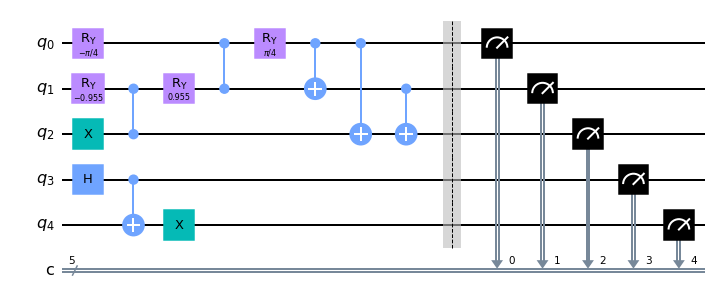

In [21]:
i_state_test = 0
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 0


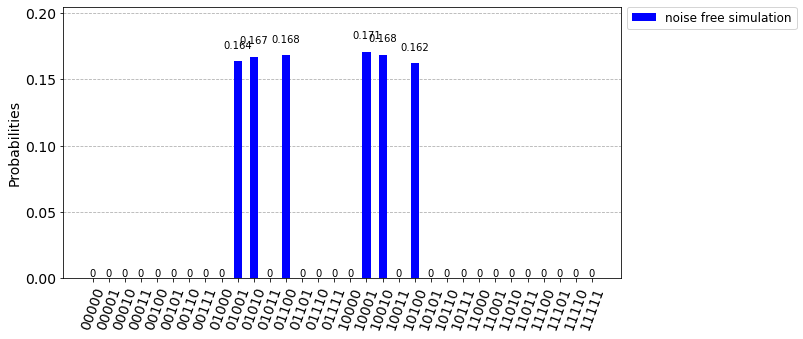

In [22]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

Example of circuit for separable state of the second type for project 2 : $|W\rangle^{\otimes X}\otimes|\Phi^+\rangle$

Ide circuit # 10


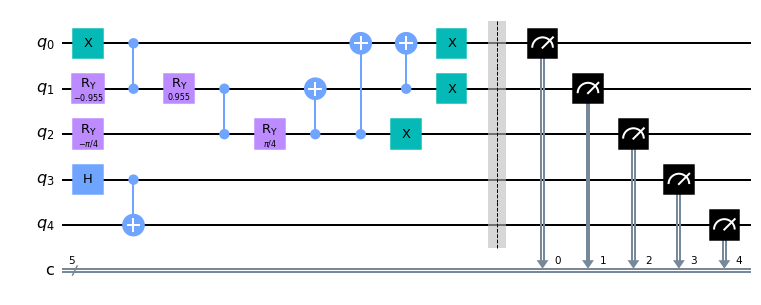

In [23]:
i_state_test = 10
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 10


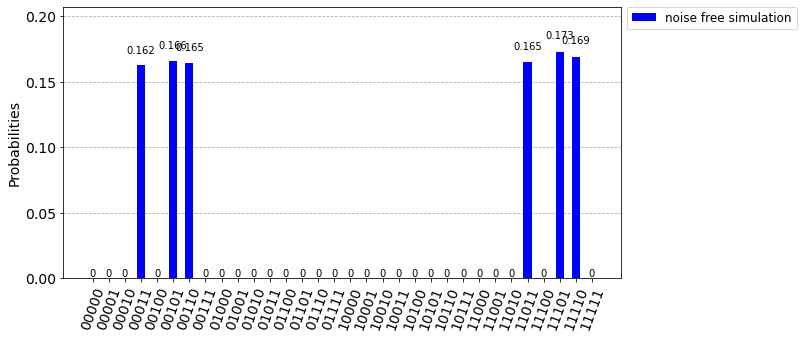

In [24]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [25]:
# try loading the dictionary of results if its creation was skipped
if len(ideal_dic) == 0:
    ideal_dic = json_dic_loader("ideal_dic_"+project_name)

In [26]:
nb_states = len(ideal_dic)
nb_labels = len(list(ideal_dic.values())[0])
s_sim = sum(list(ideal_dic.values())[0].values())

# Real device section

In [27]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [28]:
project_device = 'ibmq_quito' # you may choice here a different backend
device_name = dev_dic[project_device]
mitig_name = program_name + "_" + device_name
print(mitig_name)

AL2_Qui


In [29]:
#determine here the backend
device = provider.get_backend(project_device) # the backend names are listed here above
properties = device.properties()
coupling_map = device.configuration().coupling_map

### Transpile the basic circuits for running on real device
In this demo, these are not the circuits which were actually run on real devices (not the same transpiler seed).
The optimization level is set to 2 instead of 3 in real experiments, for speed and also because at this moment there is a transpiler error occuring for ibmqx2: 'Maximum iteration reached. max_iteration=1000' 

In [30]:
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))
project_name = mitig_name + "_" + unique_char + zfilled
print(project_name)

AL2_Qui_M000


In [31]:
# transpile
verbose = True  
summary_dic = {}
seed_transpiler_list = list(range(nb_states))
real_circs = []
start_time = time.strftime('%d/%m/%Y %H:%M:%S')    
print("Start at DMY: ",start_time)
for i_state in list(range(nb_states)):    
    # prepare circuit to be transpiled
    circuit = copy.deepcopy(circ_ori[i_state])
    if id_gates > 0:
        circuit.barrier()
        for id_gates_index in range(id_gates):
            for index, value in enumerate(qubit_list):
                circuit.id(value)
    
    new_cut.add_barrier_and_measure(circuit, qubit_list)
    
    summary = []        
    depth_list = [] 

    Q_state_opt_new = transpile(circuit, backend=device,
                        coupling_map = coupling_map,
                        seed_transpiler=seed_transpiler_list[i_state],
                        optimization_level=2,
                        initial_layout=qubit_list)

    summary_dic[i_state] = {"depth": Q_state_opt_new.depth(),
                            'circuit':Q_state_opt_new}
    real_circs.append(Q_state_opt_new)
    if verbose:
        print("circuit %2i" % i_state,"length",summary_dic[i_state]["depth"],
              "DMY: ",time.strftime('%d/%m/%Y %H:%M:%S')) 

end_time = time.strftime('%d/%m/%Y %H:%M:%S')  
print("Completed at DMY: ",end_time)    

Start at DMY:  28/02/2021 07:59:12
circuit  0 length 54 DMY:  28/02/2021 07:59:12
circuit  1 length 67 DMY:  28/02/2021 07:59:12
circuit  2 length 59 DMY:  28/02/2021 07:59:12
circuit  3 length 57 DMY:  28/02/2021 07:59:12
circuit  4 length 69 DMY:  28/02/2021 07:59:12
circuit  5 length 56 DMY:  28/02/2021 07:59:12
circuit  6 length 54 DMY:  28/02/2021 07:59:13
circuit  7 length 60 DMY:  28/02/2021 07:59:13
circuit  8 length 53 DMY:  28/02/2021 07:59:13
circuit  9 length 58 DMY:  28/02/2021 07:59:13
circuit 10 length 58 DMY:  28/02/2021 07:59:13
circuit 11 length 70 DMY:  28/02/2021 07:59:13
circuit 12 length 60 DMY:  28/02/2021 07:59:13
circuit 13 length 55 DMY:  28/02/2021 07:59:13
circuit 14 length 56 DMY:  28/02/2021 07:59:13
circuit 15 length 53 DMY:  28/02/2021 07:59:13
circuit 16 length 59 DMY:  28/02/2021 07:59:13
circuit 17 length 56 DMY:  28/02/2021 07:59:13
circuit 18 length 73 DMY:  28/02/2021 07:59:14
circuit 19 length 72 DMY:  28/02/2021 07:59:14
Completed at DMY:  28/02/

Start at DMY:  23/02/2021 15:27:39
circuit  0 length 54 DMY:  23/02/2021 15:27:39
circuit  1 length 67 DMY:  23/02/2021 15:27:39
circuit  2 length 59 DMY:  23/02/2021 15:27:40
circuit  3 length 57 DMY:  23/02/2021 15:27:40
circuit  4 length 69 DMY:  23/02/2021 15:27:40
circuit  5 length 56 DMY:  23/02/2021 15:27:41
circuit  6 length 54 DMY:  23/02/2021 15:27:41
circuit  7 length 60 DMY:  23/02/2021 15:27:41
circuit  8 length 53 DMY:  23/02/2021 15:27:41
circuit  9 length 58 DMY:  23/02/2021 15:27:41
circuit 10 length 58 DMY:  23/02/2021 15:27:42
circuit 11 length 70 DMY:  23/02/2021 15:27:42
circuit 12 length 60 DMY:  23/02/2021 15:27:42
circuit 13 length 55 DMY:  23/02/2021 15:27:42
circuit 14 length 56 DMY:  23/02/2021 15:27:42
circuit 15 length 53 DMY:  23/02/2021 15:27:43
circuit 16 length 59 DMY:  23/02/2021 15:27:43
circuit 17 length 56 DMY:  23/02/2021 15:27:43
circuit 18 length 73 DMY:  23/02/2021 15:27:43
circuit 19 length 72 DMY:  23/02/2021 15:27:43
Completed at DMY:  23/02/2021 15:27:43

In [32]:
qasm_circuit_dic = {}
for i_state in list(range(nb_states)):
    qasm_circuit_dic[str(i_state)] = real_circs[i_state].qasm()   

#### unmarkdown this one only for storing new circuit sets! 
json_dic_dumper(qasm_circuit_dic,"circuit_"+ project_name)

In [109]:
circuit_dic = json_dic_loader("circuit_"+ project_name)

In [110]:
real_circs = []
for i_state in list(range(nb_states)): 
    real_circs.append(QuantumCircuit().from_qasm_str(circuit_dic[str(i_state)]))

In [111]:
i_state_test = 11
print(project_device, "circuit #",i_state_test,
      "circuit length:",real_circs[i_state_test].depth()) 

ibmq_quito circuit # 11 circuit length: 70


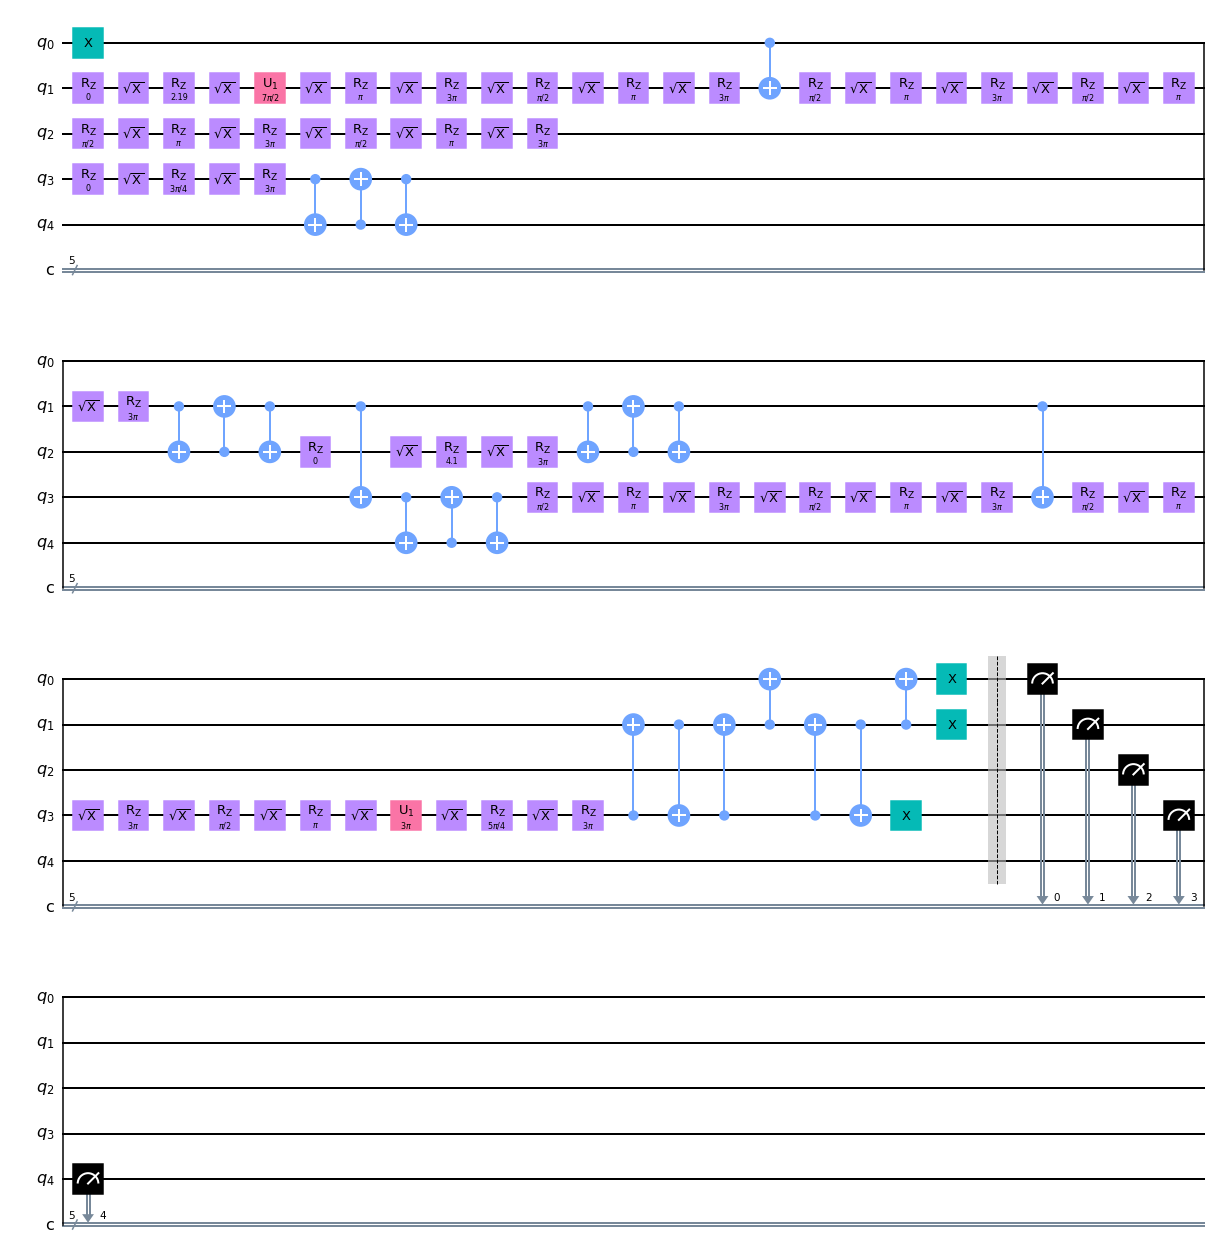

In [112]:
# you may want to skip this if large nb of id gates before measurement
real_circs[i_state_test].draw(output='mpl')

ibmq_quito circuit # 11 on noise free simulator


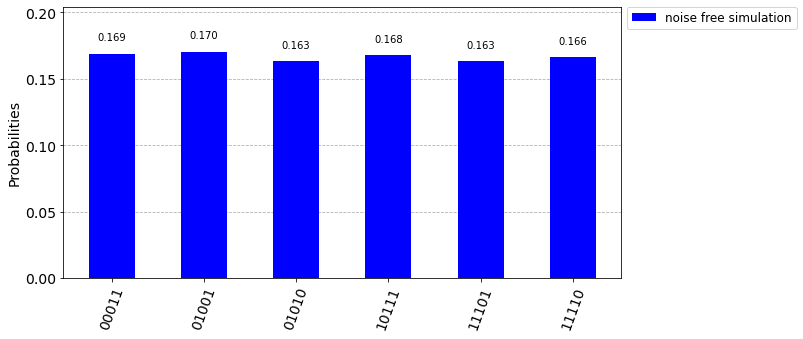

In [113]:
#check a circuit on noise-free simulator
job_simul = execute(real_circs[i_state_test], backend=simulator, shots=s_sim)
print(project_device, "circuit #",i_state_test, "on noise free simulator")
plot_histogram(job_simul.result().get_counts(),
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

In [135]:
from pprint import pprint as pp_pprint


In [140]:
for i_state_test in range(20): 
    print(i_state_test,
            "depth",real_circs[i_state_test].depth(),
            "size", real_circs[i_state_test].size(),
            "cx",real_circs[i_state_test].num_nonlocal_gates(),
            json.dumps(real_circs[i_state_test].count_ops()))

0 depth 54 size 87 cx 9 {"rz": 34, "sx": 33, "cx": 9, "measure": 5, "u1": 4, "x": 2, "barrier": 1}
1 depth 67 size 97 cx 18 {"rz": 36, "sx": 33, "cx": 18, "measure": 5, "u1": 3, "x": 2, "barrier": 1}
2 depth 59 size 96 cx 16 {"rz": 38, "sx": 33, "cx": 16, "measure": 5, "x": 2, "u1": 2, "barrier": 1}
3 depth 57 size 93 cx 15 {"rz": 34, "sx": 33, "cx": 15, "measure": 5, "u1": 4, "x": 2, "barrier": 1}
4 depth 69 size 99 cx 20 {"rz": 36, "sx": 33, "cx": 20, "measure": 5, "u1": 3, "x": 2, "barrier": 1}
5 depth 56 size 92 cx 14 {"rz": 34, "sx": 33, "cx": 14, "measure": 5, "u1": 4, "x": 2, "barrier": 1}
6 depth 54 size 95 cx 16 {"rz": 36, "sx": 33, "cx": 16, "measure": 5, "u1": 3, "x": 2, "barrier": 1}
7 depth 60 size 97 cx 17 {"rz": 38, "sx": 33, "cx": 17, "measure": 5, "x": 2, "u1": 2, "barrier": 1}
8 depth 53 size 93 cx 14 {"rz": 36, "sx": 33, "cx": 14, "measure": 5, "u1": 3, "x": 2, "barrier": 1}
9 depth 58 size 94 cx 16 {"rz": 34, "sx": 33, "cx": 16, "measure": 5, "u1": 4, "x": 2, "barri

In [143]:
pp_pprint(json.dumps(real_circs[2].count_ops()))

'{"rz": 38, "sx": 33, "cx": 16, "measure": 5, "x": 2, "u1": 2, "barrier": 1}'
